# PatchFool Attack in PyTorch

## Install ImageNet stubs and [timm](https://pypi.org/project/timm/)

In [ ]:
!pip install git+https://github.com/nottombrown/imagenet_stubs

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import IMAGENET_2012_LABELS_REVERSE, label_to_name

In [ ]:
!pip install timm

import os
os.environ['TIMM_FUSED_ATTN'] = '0'
import timm

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image

from art.attacks.evasion import PatchFoolPyTorch
from art.estimators.classification import PyTorchClassifier

In [5]:
def name_to_label(name):
    try:
        return IMAGENET_2012_LABELS_REVERSE[name]
    except KeyError:
        for names, idx in IMAGENET_2012_LABELS_REVERSE.items():
            if name in names:
                return idx

## Load test images and labels from the ImageNet stubs repository.

In [6]:
from torchvision import transforms

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])

In [7]:
images_list = list()
labels_list = list()
for idx, image_path in enumerate(imagenet_stubs.get_image_paths()):
    image = Image.open(image_path)
    images_list.append(transform(image).numpy())
    name = os.path.splitext(os.path.basename(image_path))[0]
    labels_list.append(name_to_label(name.replace('_', ' ')))

x = np.array(images_list)
y = np.array(labels_list)

## Load the pretrained DeiT-B model.

In [8]:
model = timm.create_model('deit_base_patch16_224', pretrained=True)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

## Create a PyTorchClassifier instance.

In [9]:
IMAGENET_DEFAULT_MEAN = [0.485, 0.456, 0.406]
IMAGENET_DEFAULT_STD = [0.229, 0.224, 0.225]

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),
    nb_classes=1000,
    clip_values=(0.0, 1.0),
    preprocessing=(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
)

## Evaluate the classifier's accuracy on benign test examples.

In [11]:
predictions = classifier.predict(x)
accuracy = np.sum(np.argmax(predictions, axis=1) == y) / len(y)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
print(np.argmax(predictions, axis=1))

Accuracy on benign test examples: 93.75%
[658  79 880 119 249 557 640 856 162 931 267 353 105 797 377 681]


## Get a list of the model's attention layers

From the full list of the model's graph nodes, select those whose activations are needed for obtaining the attention weights.

In [ ]:
train_nodes, eval_nodes = classifier.get_node_names()

In [13]:
train_nodes
eval_nodes

['x',
 '_model.patch_embed.getattr',
 '_model.patch_embed.getitem',
 '_model.patch_embed.getitem_1',
 '_model.patch_embed.getitem_2',
 '_model.patch_embed.getitem_3',
 '_model.patch_embed.eq',
 '_model.patch_embed._assert',
 '_model.patch_embed.eq_1',
 '_model.patch_embed._assert_1',
 '_model.patch_embed.proj',
 '_model.patch_embed.flatten',
 '_model.patch_embed.transpose',
 '_model.patch_embed.norm',
 '_model._model_pos_embed',
 '_model._model_cls_token',
 '_model.getattr',
 '_model.getitem',
 '_model.expand',
 '_model.cat',
 '_model.add',
 '_model.pos_drop',
 '_model.patch_drop',
 '_model.norm_pre',
 '_model.blocks.0.norm1',
 '_model.blocks.0.attn.getattr',
 '_model.blocks.0.attn.getitem',
 '_model.blocks.0.attn.getitem_1',
 '_model.blocks.0.attn.getitem_2',
 '_model.blocks.0.attn.qkv',
 '_model.blocks.0.attn.reshape',
 '_model.blocks.0.attn.permute',
 '_model.blocks.0.attn.unbind',
 '_model.blocks.0.attn.getitem_3',
 '_model.blocks.0.attn.getitem_4',
 '_model.blocks.0.attn.getitem_5

In the case of DeiT-B model, the attention weights can be obtained by the output of the 12 attention layers after the softmax function.

In [14]:
attention_nodes = [
            "_model.blocks.0.attn.softmax",
            "_model.blocks.1.attn.softmax",
            "_model.blocks.2.attn.softmax",
            "_model.blocks.3.attn.softmax",
            "_model.blocks.4.attn.softmax",
            "_model.blocks.5.attn.softmax",
            "_model.blocks.6.attn.softmax",
            "_model.blocks.7.attn.softmax",
            "_model.blocks.8.attn.softmax",
            "_model.blocks.9.attn.softmax",
            "_model.blocks.10.attn.softmax",
            "_model.blocks.11.attn.softmax",
        ]

## Instantiate the attack by passing the nodes list and the patch size used by the DeiT-B model.

In [15]:
attack = PatchFoolPyTorch(estimator=classifier, attention_nodes=attention_nodes, patch_size=16, max_iter=250)
x_test_adv = attack.generate(x=x)

## Evaluate the classifier's accuracy on adversarial test examples.

In [16]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == y) / len(y)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))
print(np.argmax(predictions, axis=1))

Accuracy on adversarial test examples: 37.5%
[658 836 880  99 248 755 600 866 167 931  80 353 105 671 380 462]


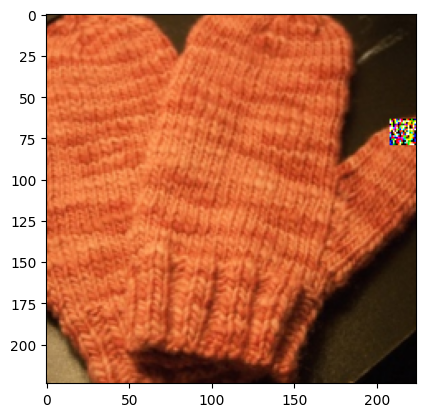

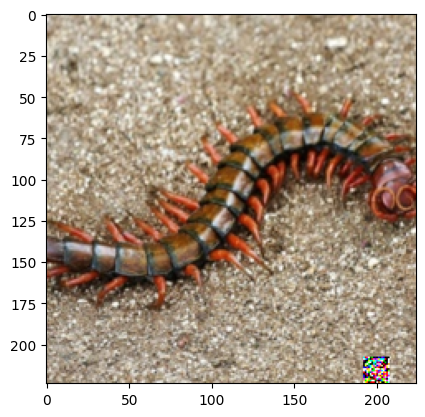

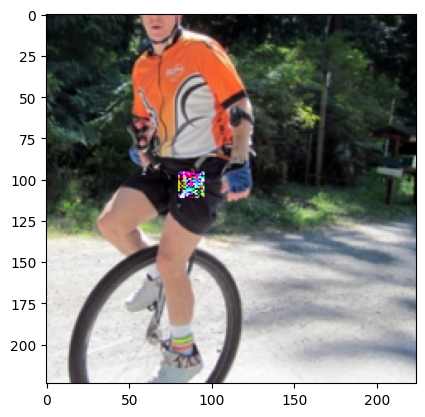

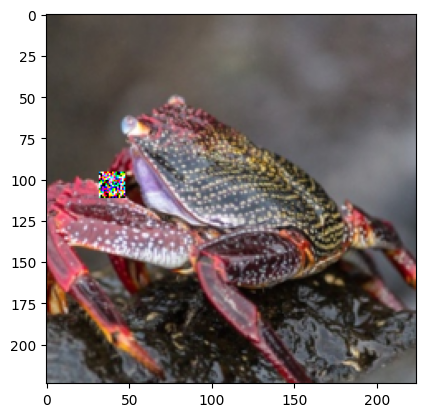

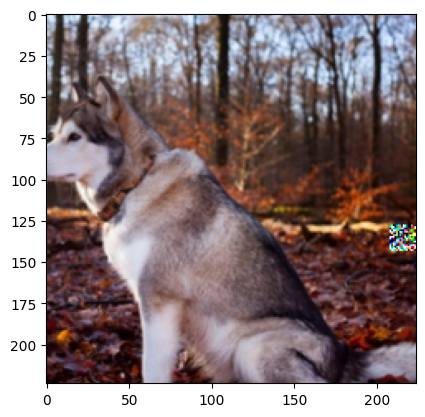

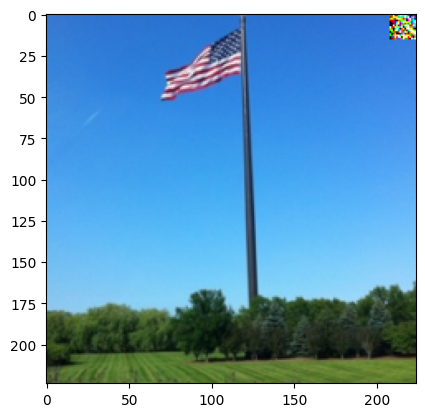

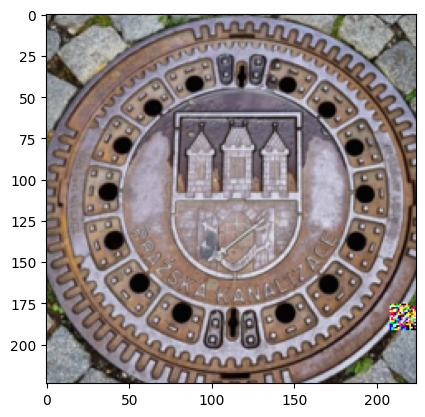

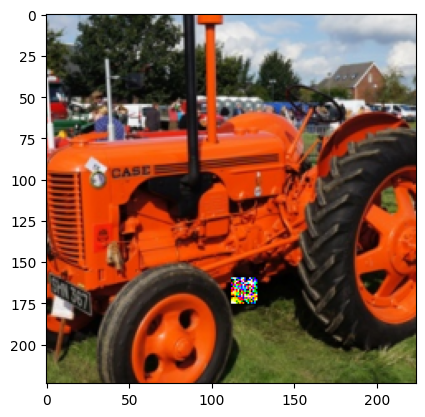

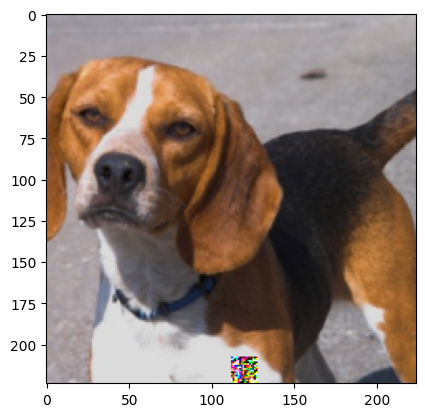

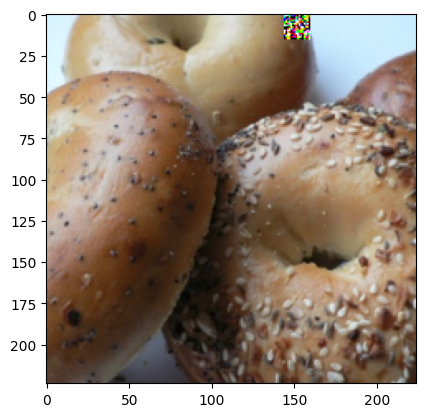

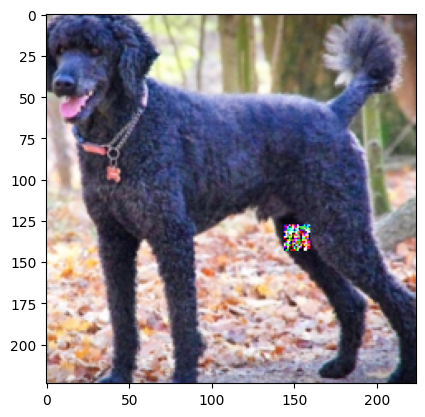

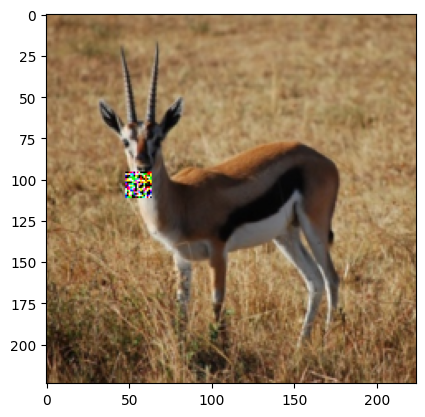

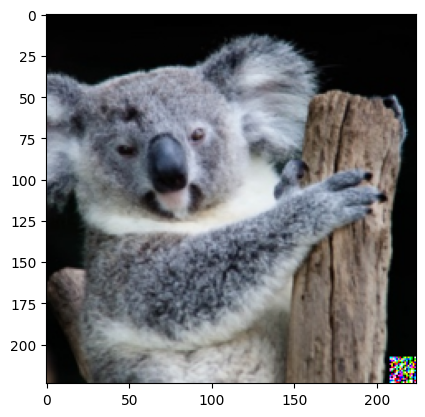

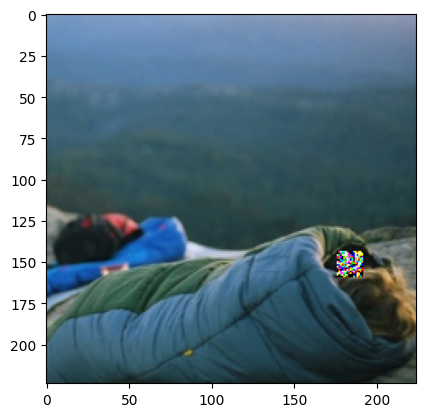

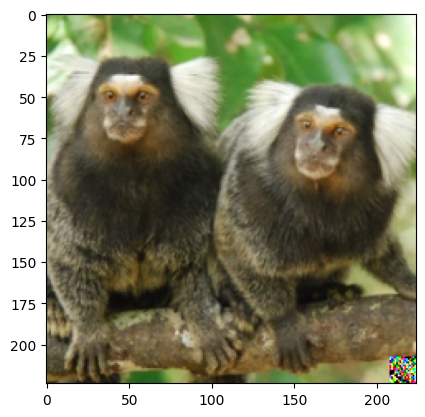

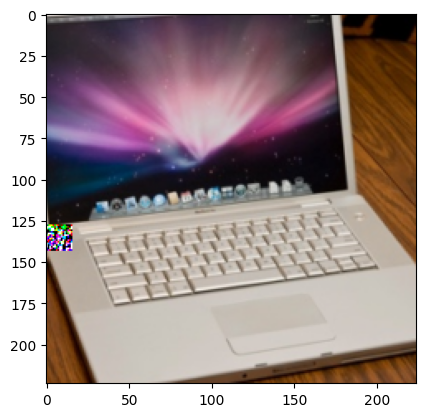

In [17]:
x_plot = np.transpose(x_test_adv, (0, 2, 3, 1))
for i in range(x_test_adv.shape[0]):
    plt.figure(i)
    plt.imshow(x_plot[i, ...])
